In [53]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 1.8 ms, sys: 6.11 ms, total: 7.91 ms
Wall time: 26.2 ms


True

In [54]:
df_reviews = pd.read_csv(
    config.interim_dir / "olist_order_reviews_translated_label_merged.csv",
)
df_reviews["review_creation_date"] = pd.to_datetime(df_reviews["review_creation_date"])
df_reviews["review_creation_month"] = df_reviews["review_creation_date"].dt.to_period(
    "M"
)
df_reviews["review_answer_timestamp"] = pd.to_datetime(
    df_reviews["review_answer_timestamp"]
)
df_reviews["review_answer_month"] = df_reviews["review_answer_timestamp"].dt.to_period(
    "M"
)
df_reviews["review_answer_date"] = df_reviews["review_answer_timestamp"].dt.to_period(
    "D"
)
df_orders = pd.read_csv(config.interim_dir / "olist_orders_customer_merged.csv")
df_item_products = pd.read_csv(
    config.interim_dir / "olist_item_product_seller_merged.csv"
)
df_orders_item_products_merged = pd.merge(
    df_orders, df_item_products, on="order_id", how="left"
)
assert (
    df_orders_item_products_merged["order_id"].nunique()
    == df_orders["order_id"].nunique()
)
df_orders_item_products_review_merged = pd.merge(
    df_orders_item_products_merged,
    df_reviews,
    on="order_id",
    how="left",
)
assert (
    df_orders_item_products_review_merged["order_id"].nunique()
    == df_orders_item_products_merged["order_id"].nunique()
)

df_review_no_null = (
    df_reviews.dropna(subset=["review_comment_message_en"])[
        [
            "review_id",
            "review_comment_message_en",
            "label_score",
            "label_translated",
            "modified_review_score",
            "meaningful_words",
        ]
    ]
    .drop_duplicates()
    .reset_index()
    .drop(columns=["index"])
)
df_reviews_unique = df_reviews[
    [
        "review_id",
        "review_comment_message_en",
        "label_score",
        "label_translated",
        "modified_review_score",
        "meaningful_words",
    ]
].drop_duplicates()
print(f"df_reviews_unique.shape: {df_reviews_unique.shape}")
print(f"df_review_no_null.shape: {df_review_no_null.shape}")


df_reviews_unique.shape: (98410, 6)
df_review_no_null.shape: (40650, 6)


In [55]:
df_orders_item_products_review_merged["is_city_same_between_customer_and_seller"] = (
    df_orders_item_products_merged["customer_city"]
    == df_orders_item_products_merged["seller_city"]
).astype(int)
df_orders_item_products_review_merged[
    "is_zip_code_prefix_same_between_customer_and_seller"
] = (
    df_orders_item_products_merged["customer_zip_code_prefix"]
    == df_orders_item_products_merged["seller_zip_code_prefix"]
).astype(int)
df_orders_item_products_review_merged["is_state_same_between_customer_and_seller"] = (
    df_orders_item_products_merged["customer_state"]
    == df_orders_item_products_merged["seller_state"]
).astype(int)

In [56]:
y, x = (
    df_orders_item_products_review_merged.dropna(subset=["modified_review_score"])[
        "modified_review_score"
    ],
    df_orders_item_products_review_merged.dropna(subset=["modified_review_score"]).drop(
        columns=[
            "customer_city",
            "seller_city",
            "customer_zip_code_prefix",
            "seller_zip_code_prefix",
            "customer_state",
            "seller_state",
            "order_id",
            "customer_id",
            "order_purchase_timestamp",
            "order_purchase_date",
            "order_approved_date",
            "order_approved_at",
            "order_delivered_carrier_date",
            "order_delivered_customer_date",
            "order_estimated_delivery_date",
            "customer_unique_id",
            "order_item_id",
            "product_id",
            "seller_id",
            "review_id",
            "review_score",
            "review_comment_title",
            "review_comment_message",
            "review_creation_date",
            "review_answer_timestamp",
            "review_comment_title_en",
            "review_comment_message_en",
            "label_score",
            "meaningful_words",
            "modified_review_score",
            "review_creation_month",
            "review_answer_month",
            "review_answer_date",
            "product_category_name",
            "label_translated",
        ]
    ),
)

In [52]:
x[
    [
        "approved_span_hours",
        "estimated_delivery_span_hours",
        "order_delivered_carrier_date_span_from_purchase_hours",
        "order_delivered_customer_date_span_from_purchase_hours",
        "order_delivered_customer_date_span_from_delivery_carrier_hours",
    ]
]

,approved_span_hours,estimated_delivery_span_hours,order_delivered_carrier_date_span_from_purchase_hours,order_delivered_customer_date_span_from_purchase_hours,order_delivered_customer_date_span_from_delivery_carrier_hours
0,0.178333,373.057500,56.974167,202.477778,145.503611
1,30.713889,459.306389,41.823056,330.768889,288.945833
2,0.276111,639.353056,5.186389,225.461111,220.274722
3,0.298056,628.531667,90.198056,317.010000,226.811944
4,1.030556,290.689167,22.465278,68.973056,46.507778
...,...,...,...,...,...
114087,0.194167,563.017222,34.395556,532.649444,498.253889
114088,0.292500,729.221389,30.095278,596.626111,566.530833
114089,0.131667,890.525833,90.110000,410.074167,319.964167
114090,0.131667,890.525833,90.110000,410.074167,319.964167


Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.842433	valid_1's multi_logloss: 0.920963
[200]	training's multi_logloss: 0.781914	valid_1's multi_logloss: 0.909021
[300]	training's multi_logloss: 0.733427	valid_1's multi_logloss: 0.90189
[400]	training's multi_logloss: 0.690525	valid_1's multi_logloss: 0.896326
[500]	training's multi_logloss: 0.650133	valid_1's multi_logloss: 0.891149
[600]	training's multi_logloss: 0.613744	valid_1's multi_logloss: 0.887507
[700]	training's multi_logloss: 0.580564	valid_1's multi_logloss: 0.884613
[800]	training's multi_logloss: 0.550182	valid_1's multi_logloss: 0.882633
[900]	training's multi_logloss: 0.521651	valid_1's multi_logloss: 0.880544
[1000]	training's multi_logloss: 0.495342	valid_1's multi_logloss: 0.879124
Did not meet early stopping. Best iteration is:
[997]	training's multi_logloss: 0.496065	valid_1's multi_logloss: 0.879101
Accuracy: 0.6815

Classification Report:
              precision  

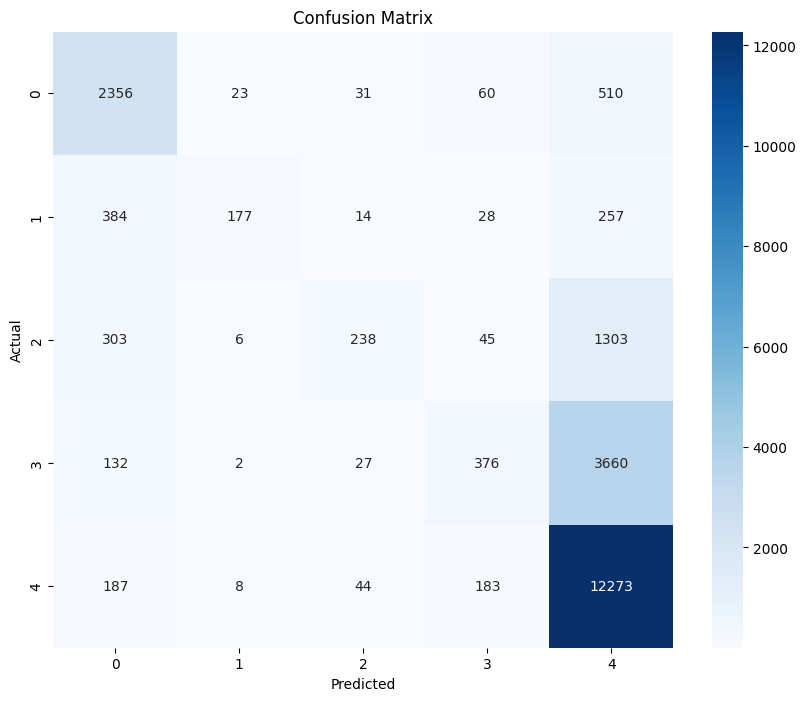


Top 10 most important features:
                                              feature  importance
28                                approved_span_hours       10941
23                      product_category_name_english       10607
30  order_delivered_carrier_date_span_from_purchas...       10596
29                      estimated_delivery_span_hours        9975
31  order_delivered_customer_date_span_from_purcha...        9464
32  order_delivered_customer_date_span_from_delive...        9368
17                         product_description_lenght        9267
14                                      freight_value        8248
16                                product_name_lenght        6449
19                                   product_weight_g        6356


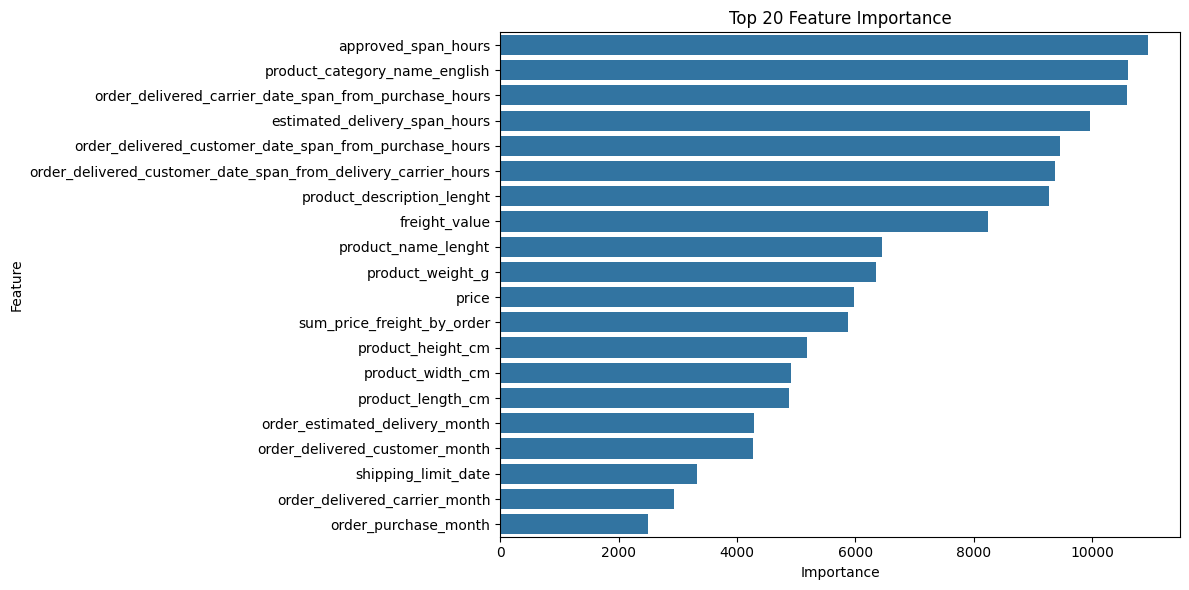

In [46]:
# 必要なライブラリのインポート
import pandas as pd

span_columns = [
    "approved_span",
    "estimated_delivery_span",
    "order_delivered_carrier_date_span_from_purchase",
    "order_delivered_customer_date_span_from_purchase",
    "order_delivered_customer_date_span_from_delivery_carrier",
]

categorical_features = [
    "order_status",
    "order_purchase_month",
    "order_purchase_weekday",
    "order_approved_month",
    "order_approved_weekday",
    "order_delivered_carrier_month",
    "order_delivered_carrier_weekday",
    "order_delivered_customer_month",
    "order_delivered_customer_weekday",
    "order_estimated_delivery_month",
    "order_estimated_delivery_weekday",
    # "customer_city",
    # "customer_state",
    "product_category_name_english",
    # "seller_city",
    # "seller_state",
    "label_translated",
    "shipping_limit_date",
]

for col in span_columns:
    if col in x.columns:
        # timedeltaをhoursに変換（seconds / 3600）
        x[f"{col}_hours"] = pd.to_timedelta(x[col]).dt.total_seconds() / 3600
        # 元の列を削除
        x = x.drop(columns=[col])

# カテゴリカル変数をLightGBMが扱える形式に変換
for col in categorical_features:
    if col in x.columns:
        x[col] = x[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# ラベルの範囲を0から始まるように調整
y_train = y_train - 1
y_test = y_test - 1

# LightGBMのデータセットを作成
train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical_features
)
valid_data = lgb.Dataset(
    X_test,
    label=y_test,
    categorical_feature=categorical_features,
    reference=train_data,
)

# モデルのパラメータを設定（分類用）
params = {
    "objective": "multiclass",  # 多クラス分類
    "num_class": len(y.unique()),  # クラス数
    "metric": "multi_logloss",  # 評価指標
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "verbose": -1,
}

# モデルの学習
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
    ],
)

# テストデータで予測
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1) + 1  # クラスのインデックスを1-5のスコアに変換

# モデルの評価
accuracy = accuracy_score(y_test + 1, y_pred_class)  # y_testを元のスケールに戻して評価
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(
    classification_report(y_test + 1, y_pred_class)
)  # y_testを元のスケールに戻して評価

# 混同行列の表示
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test + 1, y_pred_class)  # y_testを元のスケールに戻して表示
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 特徴量の重要度を表示
importance = pd.DataFrame(
    {"feature": model.feature_name(), "importance": model.feature_importance()}
)
importance = importance.sort_values("importance", ascending=False)
print("\nTop 10 most important features:")
print(importance.head(10))

# 特徴量重要度の可視化
plt.figure(figsize=(12, 6))
sns.barplot(data=importance.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [48]:
importance

,feature,importance
28,approved_span_hours,10941
23,product_category_name_english,10607
30,order_delivered_carrier_date_span_from_purchas...,10596
29,estimated_delivery_span_hours,9975
31,order_delivered_customer_date_span_from_purcha...,9464
32,order_delivered_customer_date_span_from_delive...,9368
17,product_description_lenght,9267
14,freight_value,8248
16,product_name_lenght,6449
19,product_weight_g,6356


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START feature_fraction=1.0, learning_rate=0.05, max_depth=20, min_child_samples=10, n_estimators=500, num_leaves=100
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[CV 2/5; 1/10] START feature_fraction=1.0, learning_rate=0.05, max_depth=20, min_child_samples=10, n_estimators=500, num_leaves=100
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

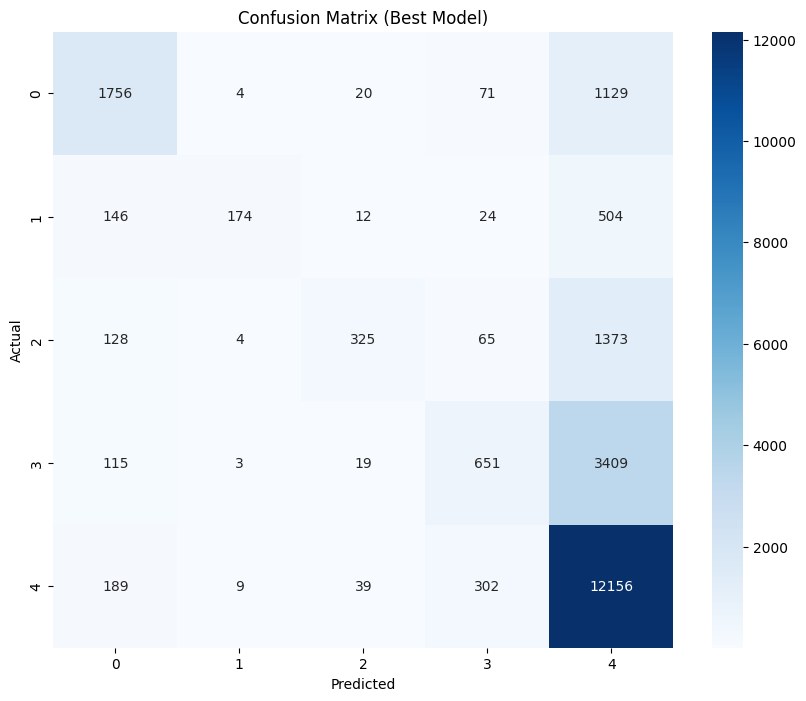


Top 10 most important features:
                                              feature  importance
27                                approved_span_hours       21158
29  order_delivered_carrier_date_span_from_purchas...       20110
28                      estimated_delivery_span_hours       18969
17                         product_description_lenght       17163
30  order_delivered_customer_date_span_from_purcha...       17089
31  order_delivered_customer_date_span_from_delive...       16820
14                                      freight_value       15359
16                                product_name_lenght       11998
19                                   product_weight_g       11908
15                         sum_price_freight_by_order       10981


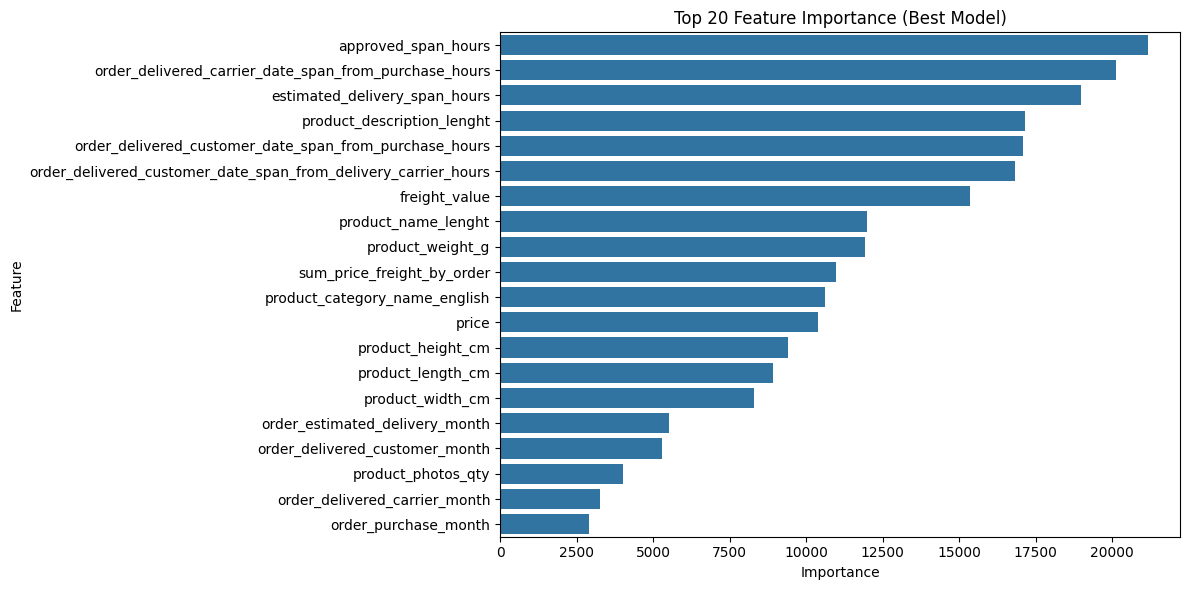

In [58]:
# 必要なライブラリのインポート


span_columns = [
    "approved_span",
    "estimated_delivery_span",
    "order_delivered_carrier_date_span_from_purchase",
    "order_delivered_customer_date_span_from_purchase",
    "order_delivered_customer_date_span_from_delivery_carrier",
]

categorical_features = [
    "order_status",
    "order_purchase_month",
    "order_purchase_weekday",
    "order_approved_month",
    "order_approved_weekday",
    "order_delivered_carrier_month",
    "order_delivered_carrier_weekday",
    "order_delivered_customer_month",
    "order_delivered_customer_weekday",
    "order_estimated_delivery_month",
    "order_estimated_delivery_weekday",
    "product_category_name_english",
    # "customer_city",
    # "customer_state",
    # "seller_city",
    # "seller_state",
    # "label_translated",
    "shipping_limit_date",
]

for col in span_columns:
    if col in x.columns:
        # timedeltaをhoursに変換（seconds / 3600）
        x[f"{col}_hours"] = pd.to_timedelta(x[col]).dt.total_seconds() / 3600
        # 元の列を削除
        x = x.drop(columns=[col])

# カテゴリカル変数をLightGBMが扱える形式に変換
for col in categorical_features:
    if col in x.columns:
        x[col] = x[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# ラベルの範囲を0から始まるように調整
y_train = y_train - 1
y_test = y_test - 1


def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="micro")


# ランダムサーチ用のパラメータ範囲を定義
param_dist = {
    "num_leaves": [31, 50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 500],
    "feature_fraction": [0.7, 0.9, 1.0],
    "min_child_samples": [10, 30, 50],
    "max_depth": [-1, 5, 10, 20],
    # "reg_alpha": [0, 0.1, 1],
    # "reg_lambda": [0, 0.1, 1],
}

# LightGBMClassifierの初期化
lgb_clf = LGBMClassifier(
    objective="multiclass",
    num_class=len(y.unique()),
    metric="multi_logloss",
    boosting_type="gbdt",
    verbose=1,
    random_state=42,
)

# micro-f1スコアをscorerとして設定
micro_f1_scorer = make_scorer(micro_f1)


# コールバック関数の定義 (各iterationごとに実行)
def callback(study, trial):
    print(f"Trial {trial.number}: Value {trial.value} (Best: {study.best_value})")


# ランダムサーチの実行
random_search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=10,  # 試行回数
    scoring="accuracy",  # micro-f1スコアを使用
    # scoring=micro_f1_scorer,  # micro-f1スコアを使用
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=10,
)

# モデルの学習
random_search.fit(X_train, y_train, categorical_feature=categorical_features)

# 最良のパラメータとスコアを表示
print("Best parameters:", random_search.best_params_)
print("Best cross-validation micro-f1 score: {:.4f}".format(random_search.best_score_))

# 最良のモデルを使用して予測
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# テストセットでのmicro-f1スコアを計算
micro_f1_test = f1_score(y_test + 1, y_pred + 1, average="micro")
print(f"\nTest set micro-f1 score: {micro_f1_test:.4f}")

# 分類レポートの表示
print("\nClassification Report:")
print(classification_report(y_test + 1, y_pred + 1))

# 混同行列の表示
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test + 1, y_pred + 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 特徴量の重要度を表示
importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": best_model.feature_importances_}
)
importance = importance.sort_values("importance", ascending=False)
print("\nTop 10 most important features:")
print(importance.head(10))

# 特徴量重要度の可視化
plt.figure(figsize=(12, 6))
sns.barplot(data=importance.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importance (Best Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [20]:
df_orders_item_products_review_merged_modified_review_score_no_null = (
    df_orders_item_products_review_merged.dropna(subset=["modified_review_score"]).drop(
        columns=[
            # "order_id",
            "customer_id",
            "order_purchase_timestamp",
            "order_purchase_date",
            "order_approved_date",
            "order_approved_at",
            "order_delivered_carrier_date",
            "order_delivered_customer_date",
            "order_estimated_delivery_date",
            "customer_unique_id",
            "order_item_id",
            "product_id",
            "seller_id",
            "review_id",
            "review_score",
            "review_comment_title",
            "review_comment_message",
            "review_creation_date",
            "review_answer_timestamp",
            "review_comment_title_en",
            "review_comment_message_en",
            "label_score",
            "meaningful_words",
            "review_creation_month",
            "review_answer_month",
            "review_answer_date",
            "product_category_name",
        ]
    )
)

In [32]:
df_orders_item_products_review_merged_modified_review_score_no_null.groupby(
    ["product_category_name_english", "customer_city", "seller_city"]
).agg({"modified_review_score": "mean", "order_id": "nunique"}).sort_values(
    by="order_id", ascending=False
).reset_index().to_excel(
    config.results_agg_dir
    / "agg_product_category_name_english_customer_city_seller_city.xlsx",
    index=False,
)